In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '../../../devel/lib/python2.7/dist-packages')
sys.path.insert(0, '../../../src/merganser/packages/merganser_line_detector/include')
sys.path.insert(0, '../../../src/merganser/packages/merganser_bezier/include')

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import json

In [4]:
from merganser_bezier.bezier import Bezier, compute_curve
from merganser_bezier.kalman import KalmanFilter, rotation, block_diag
from merganser_bezier.utils.kinematics import transform

In [5]:
filename = 'skeletons_log_11-25_2.json'
with open(filename, 'rb') as f:
    skeletons_frames = json.load(f)

# Tests

## Classic

In [6]:
cloud = np.array(skeletons_frames[0]['white'][0]).T

In [7]:
bezier = Bezier(4, 20)
bezier.initialise(cloud)
bezier.closed_form(cloud)

In [8]:
kalman = KalmanFilter(dimension=4, process_noise=.01)
kalman.reset(bezier.controls.reshape(-1))

<function matplotlib.pyplot.show>

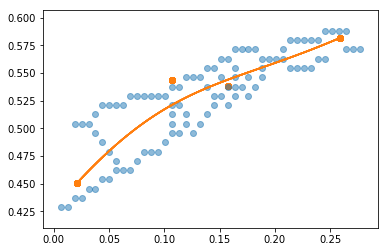

In [9]:
controls = np.random.multivariate_normal(bezier.controls.reshape(-1), kalman.sigma, size=20).reshape(-1, 4, 2)

for control in controls:
    
    plt.plot(*compute_curve(control, 100).T, color='C1', alpha=.5)
    plt.scatter(*control.T, color='C1', alpha=.5)
    
plt.scatter(*cloud.T, alpha=.5, color='C0')
plt.axis('equal')
plt.show

In [10]:
v, omega, dt = .2, 2.5, .1
dx = v * dt
dtheta = omega * dt

In [11]:
cloud_ = transform(-v, -omega, dt, cloud) + .01 * np.random.normal(size=cloud.shape)

In [12]:
kalman.predict(dx, dtheta)

<function matplotlib.pyplot.show>

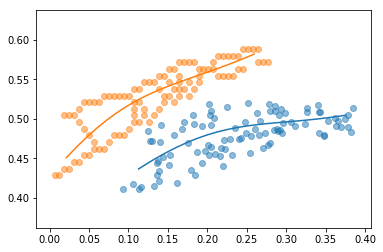

In [13]:
plt.plot(*compute_curve(kalman.mu.reshape((4, 2))).T)
plt.plot(*bezier().T)
plt.scatter(*cloud_.T, alpha=.5)
plt.scatter(*cloud.T, alpha=.5)
plt.axis('equal')
plt.show

In [14]:
bezier.controls = kalman.mu.reshape((4, 2))

In [15]:
kalman.correct(cloud_)

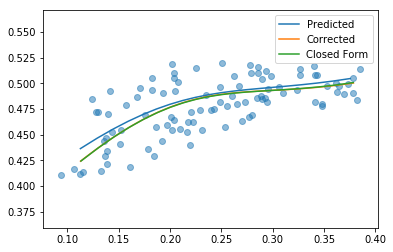

In [16]:
plt.plot(*bezier().T, label='Predicted')
plt.plot(*compute_curve(kalman.mu.reshape((4, 2)), 100).T, label='Corrected')

bezier.closed_form(cloud_)
plt.plot(*bezier().T, label='Closed Form')

plt.scatter(*cloud_.T, alpha=.5)
plt.axis('equal')

plt.legend()

plt.show()

<function matplotlib.pyplot.show>

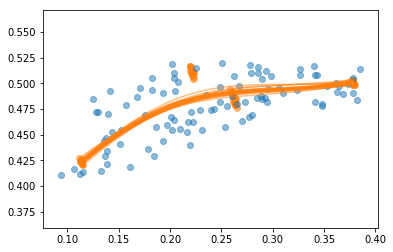

In [17]:
controls = np.random.multivariate_normal(
    bezier.controls.reshape(8), 
    kalman.sigma * block_diag(*[np.ones((2, 2)) for _ in range(4)]) * .1, 
    size=20
).reshape(-1, 4, 2)

for control in controls:
    
    plt.plot(*compute_curve(control, 100).T, color='C1', alpha=.5)
    plt.scatter(*control.T, color='C1', alpha=.5)
    
plt.scatter(*cloud_.T, alpha=.5, color='C0')
plt.axis('equal')
plt.show

# Tests

In [18]:
cloud = np.array(skeletons_frames[0]['white'][1]).T

In [19]:
bezier = Bezier(4, 20)
bezier.collapse(cloud)

<function matplotlib.pyplot.show>

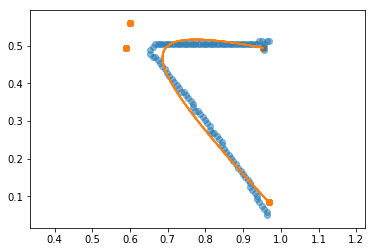

In [20]:
controls = np.random.multivariate_normal(bezier.controls.reshape(-1), bezier.filter.sigma, size=20).reshape(-1, 4, 2)

for control in controls:
    
    plt.plot(*compute_curve(control, 100).T, color='C1', alpha=.5)
    plt.scatter(*control.T, color='C1', alpha=.5)
    
plt.scatter(*cloud.T, alpha=.5, color='C0')
plt.axis('equal')
plt.show

In [21]:
v, omega, dt = .2, 2.5, .1
dx = v * dt
dtheta = omega * dt

In [22]:
cloud_ = transform(-v, -omega, dt, cloud) + .01 * np.random.normal(size=cloud.shape) + .05

In [23]:
bezier.step(dx, dtheta, cloud_)

<function matplotlib.pyplot.show>

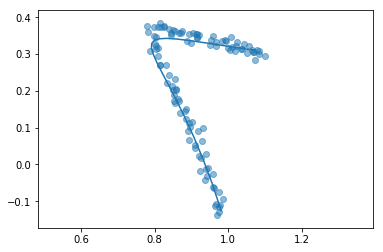

In [24]:
plt.plot(*bezier().T)
plt.scatter(*cloud_.T, alpha=.5)
plt.axis('equal')
plt.show

<function matplotlib.pyplot.show>

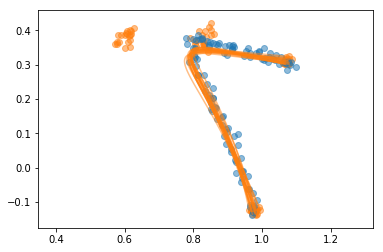

In [25]:
controls = np.random.multivariate_normal(bezier.controls.reshape(-1), bezier.filter.sigma, size=20).reshape(-1, 4, 2)

for control in controls:
    
    plt.plot(*compute_curve(control, 100).T, color='C1', alpha=.5)
    plt.scatter(*control.T, color='C1', alpha=.5)
    
plt.scatter(*cloud_.T, alpha=.5, color='C0')
plt.axis('equal')
plt.show

# Higher-order

In [26]:
cloud = np.array(skeletons_frames[0]['white'][1]).T

In [27]:
bezier = Bezier(6, 20)
bezier.collapse(cloud)

<function matplotlib.pyplot.show>

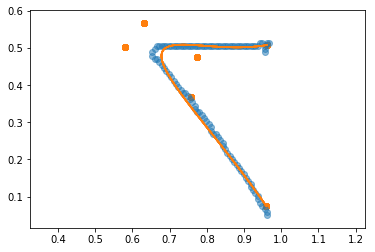

In [28]:
controls = np.random.multivariate_normal(bezier.controls.reshape(-1), bezier.filter.sigma, size=20).reshape(-1, 6, 2)

for control in controls:
    
    plt.plot(*compute_curve(control, 100).T, color='C1', alpha=.5)
    plt.scatter(*control.T, color='C1', alpha=.5)
    
plt.scatter(*cloud.T, alpha=.5, color='C0')
plt.axis('equal')
plt.show

In [29]:
v, omega, dt = .2, 2.5, .1
dx = v * dt
dtheta = omega * dt

In [30]:
cloud_ = transform(-v, -omega, dt, cloud) + .01 * np.random.normal(size=cloud.shape) + .05

In [31]:
bezier.step(dx, dtheta, cloud_)

<function matplotlib.pyplot.show>

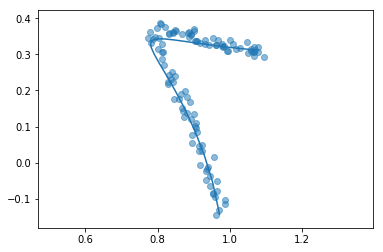

In [32]:
plt.plot(*bezier().T)
plt.scatter(*cloud_.T, alpha=.5)
plt.axis('equal')
plt.show

<function matplotlib.pyplot.show>

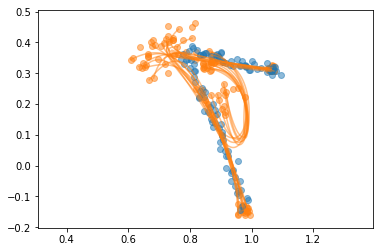

In [33]:
controls = np.random.multivariate_normal(bezier.controls.reshape(-1), bezier.filter.sigma, size=20).reshape(-1, 4, 2)

for control in controls:
    
    plt.plot(*compute_curve(control, 100).T, color='C1', alpha=.5)
    plt.scatter(*control.T, color='C1', alpha=.5)
    
plt.scatter(*cloud_.T, alpha=.5, color='C0')
plt.axis('equal')
plt.show

## Over time

In [109]:
bezier = Bezier(4, 20, process_noise=.1, loss_threshold=.01)

In [110]:
cloud_ = cloud
dt = .1

bezier.collapse(cloud_)

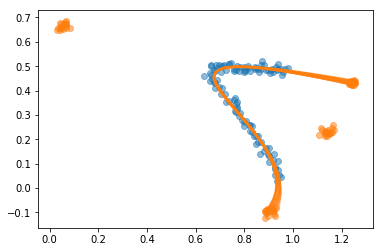

In [123]:
v, omega = np.abs(np.random.normal(size=2) * np.array([.1, .3]))

dx = v * dt
dtheta = omega * dt

cloud_ = transform(-v, -omega, dt, cloud) + .01 * np.random.normal(size=cloud.shape)

bezier.step(dx, dtheta, cloud_)

controls = np.random.multivariate_normal(bezier.controls.reshape(-1), bezier.filter.sigma, size=20).reshape(-1, 4, 2)

for control in controls:
    
    plt.plot(*compute_curve(control, 100).T, color='C1', alpha=.5)
    plt.scatter(*control.T, color='C1', alpha=.5)
    
plt.scatter(*cloud_.T, alpha=.5, color='C0')
plt.axis('equal')
plt.show()

# Following lines

In [131]:
class BezierWrapper:
    
    def __init__(self):
        
        self.beziers = dict(red=[], yellow=[], white=[])
        
        self.curve_precision = 20
        self.reg = .01
        self.eps = .001
        self.lr = .01
        self.fitting_steps = 100
        self.loss_threshold = .0005
        
    def process_cloud(self, cloud, color):
        
        choice = np.linspace(.2, .8, 4).reshape(-1, 1)
        choice = np.hstack((choice, choice))
        
        beziers = self.beziers[color]
        
        losses = np.array([b.loss(cloud) for b in beziers])
        argmin = losses.argmin() if len(losses) > 0 else -1

        if argmin > -1 and losses[argmin] < self.loss_threshold:
            bezier = beziers[argmin].copy()
        else:
            bezier = Bezier(4, self.curve_precision, reg=self.reg)
            bezier.collapse(cloud)
        
#         bezier.extrapolate(-.05, 1.05)
            
        bezier.fit(
            cloud=cloud,
            steps=self.fitting_steps,
            eps=self.eps,
            lr=self.lr,
        )
        
        return bezier, color
    
    def process_clouds(self, skeletons):
        pass

ERROR! Session/line number was not unique in database. History logging moved to new session 76


In [132]:
bw = BezierWrapper()

In [133]:
def plot_skeletons(skeletons, save=''):
    
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_facecolor('black')
    
    plt.xlim(0, 1)
    plt.ylim(0, .8)
    
    for color in ['white', 'yellow', 'red']:
        beziers = []
        for skeleton in skeletons[color]:
            
            cloud = np.array(skeleton).T

            if len(cloud) < 20:
                continue

            b, c = bw.process_cloud(cloud, color)
            
            beziers.append(b)
            
#             plt.plot(*b().T, lw=5, color='black')
            plt.plot(*b().T, lw=5, color=color)
            plt.scatter(*cloud.T, alpha=.5, c=color)
        
        bw.beziers[color] = beziers
    
    if save:
        plt.savefig(save, bbox_inches='tight', dpi=200)
        plt.close()
        
    else:
        plt.show()

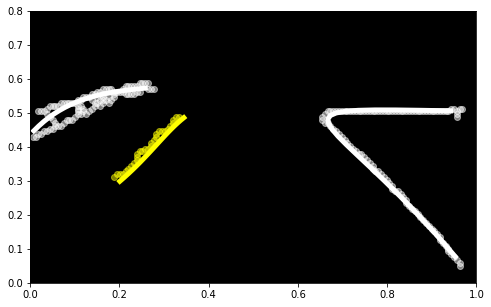

In [129]:
plot_skeletons(skeletons_frames[0]) #, 'output/skeletons_1.png')

In [130]:
from tqdm import tqdm

In [ ]:
for i, skeletons in enumerate(tqdm(skeletons_frames[150:], ascii=True, ncols=100)):
    plot_skeletons(skeletons, 'output/skeletons4/skeletons_%03d.png' % (i, ))

 87%|###################################################5       | 728/833 [10:14<1:27:09, 49.81s/it]ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/usr/lib/python2.7/inspect.py", line 1058, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/usr/lib/python2.7/inspect.py", line 1018, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/usr/lib/python2.7/inspect.py", line 453, in getsourcefile
    if hasattr(getmodule(object, filename), '__loader__'):
  File "/usr/lib/python2.7/inspect.py", line 496, in getmodule
    f = getabsfile(module)
  File

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 376, in _fixed_getinnerframes
    lines = ulinecache.getlines(file)[start:end]
  File "/usr/local/lib/python2.7/dist-packages/IPython/utils/ulinecache.py", line 34, in getlines
    encoding, _ = openpy.detect_encoding(readline)
  File "/usr/local/lib/python2.7/dist-packages/IPython/utils/openpy.py", line 95, in detect_encoding
    encoding = find_cookie(first)
  File "/usr/local/lib/python2.7/dist-packages/IPython/utils/openpy.py", line 70, in find_cookie
    matches = cookie_re.findall(line_string)
KeyboardInterrupt
